# GP Regression with Grid Structured Training Data

In this notebook, we demonstrate how to perform GP regression when your training data lies on a regularly spaced grid. For this example, we'll be modeling a 2D function where the training data is on an evenly spaced grid on (0,1)x(0, 2) with 100 grid points in each dimension. 

In other words, we have 10000 training examples. However, the grid structure of the training data will allow us to perform inference very quickly anyways.

In [1]:
import gpytorch
import torch
import math

## Make the grid and training data

In the next cell, we create the grid, along with the 10000 training examples and labels. After running this cell, we create three important tensors:

- `grid` is a tensor that is `grid_size x 2` and contains the 1D grid for each dimension.
- `train_x` is a tensor containing the full 10000 training examples.
- `train_y` are the labels. For this, we're just using a simple sine function.

In [9]:
grid_bounds = [(0, 1), (0, 2)]
grid_size = 100
grid = torch.zeros(grid_size, len(grid_bounds))
for i in range(len(grid_bounds)):
    grid_diff = float(grid_bounds[i][1] - grid_bounds[i][0]) / (grid_size - 2)
    grid[:, i] = torch.linspace(grid_bounds[i][0] - grid_diff, grid_bounds[i][1] + grid_diff, grid_size)

# Here we actually construct the full grid. We only do this in the example notebook
# to easily get the training labels. We won't need the full grid constructed ever.
grid_size = grid.size(-2)
grid_dim = grid.size(-1)
grid_data = torch.zeros(int(pow(grid_size, grid_dim)), grid_dim)
prev_points = None
for i in range(grid_dim):
    for j in range(grid_size):
        grid_data[j * grid_size ** i : (j + 1) * grid_size ** i, i].fill_(grid[j, i])
        if prev_points is not None:
            grid_data[j * grid_size ** i : (j + 1) * grid_size ** i, :i].copy_(prev_points)
    prev_points = grid_data[: grid_size ** (i + 1), : (i + 1)]
    
train_y = torch.sin((grid_data[:, 0] + grid_data[:, 1]) * (2 * math.pi)) + torch.randn_like(grid_data[:, 0]).mul(0.01)
train_x = grid_data

## Creating the GP Model

In the next cell we create our GP model. Like other scalable GP methods, we'll use a scalable kernel that wraps a base kernel. In this case, we create a `GridKernel` that wraps an `RBFKernel`.

In [10]:
class GridGPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, grid, train_x, train_y, likelihood):
        super(GridGPRegressionModel, self).__init__(train_x, train_y, likelihood)
        num_dims = train_x.size(-1)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridKernel(gpytorch.kernels.RBFKernel(), grid=grid)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GridGPRegressionModel(grid, train_x, train_y, likelihood)
        

In [4]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.log_lengthscale.item(),
        model.likelihood.log_noise.item()
    ))
    optimizer.step()

/home/jrg365/gpytorch/gpytorch/utils/cholesky.py:14: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
  potrf_list = [sub_mat.potrf() for sub_mat in mat.view(-1, *mat.shape[-2:])]
/home/jrg365/gpytorch/gpytorch/lazy/added_diag_lazy_tensor.py:66: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
  ld_one = lr_flipped.potrf().diag().log().sum() * 2


Iter 1/50 - Loss: 1.150   log_lengthscale: 0.000   log_noise: 0.000
Iter 2/50 - Loss: 1.113   log_lengthscale: -0.100   log_noise: -0.100
Iter 3/50 - Loss: 1.070   log_lengthscale: -0.196   log_noise: -0.200
Iter 4/50 - Loss: 1.019   log_lengthscale: -0.290   log_noise: -0.300
Iter 5/50 - Loss: 0.963   log_lengthscale: -0.385   log_noise: -0.400
Iter 6/50 - Loss: 0.899   log_lengthscale: -0.481   log_noise: -0.500
Iter 7/50 - Loss: 0.819   log_lengthscale: -0.579   log_noise: -0.601
Iter 8/50 - Loss: 0.718   log_lengthscale: -0.676   log_noise: -0.702
Iter 9/50 - Loss: 0.612   log_lengthscale: -0.774   log_noise: -0.804
Iter 10/50 - Loss: 0.520   log_lengthscale: -0.874   log_noise: -0.907
Iter 11/50 - Loss: 0.446   log_lengthscale: -0.972   log_noise: -1.011
Iter 12/50 - Loss: 0.384   log_lengthscale: -1.066   log_noise: -1.115
Iter 13/50 - Loss: 0.327   log_lengthscale: -1.153   log_noise: -1.221
Iter 14/50 - Loss: 0.273   log_lengthscale: -1.232   log_noise: -1.326
Iter 15/50 - Loss

## Testing the model

In the next cell, we create a set of 400 test examples and make predictions. Note that unlike other scalable GP methods, testing is more complicated. Because our test data can be different from the training data, in general we may not be able to avoid creating a `num_train x num_test` (e.g., `10000 x 400`) kernel matrix between the training and test data.

For this reason, if you have large numbers of test points, memory may become a concern. The time complexity should still be reasonable, however, because we will still exploit structure in the train-train covariance matrix.

In [5]:
model.eval()
likelihood.eval()
n = 20
test_x = torch.zeros(int(pow(n, 2)), 2)
for i in range(n):
    for j in range(n):
        test_x[i * n + j][0] = float(i) / (n-1)
        test_x[i * n + j][1] = float(j) / (n-1)

with torch.no_grad(), gpytorch.fast_pred_var():
    observed_pred = likelihood(model(test_x))

/home/jrg365/gpytorch/gpytorch/utils/cholesky.py:14: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
  potrf_list = [sub_mat.potrf() for sub_mat in mat.view(-1, *mat.shape[-2:])]
/home/jrg365/gpytorch/gpytorch/lazy/added_diag_lazy_tensor.py:66: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
  ld_one = lr_flipped.potrf().diag().log().sum() * 2


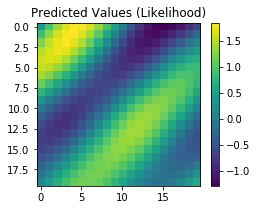

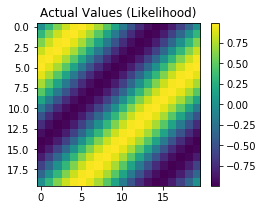

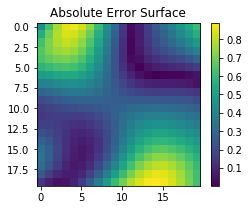

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

pred_labels = observed_pred.mean.view(n, n)

# Calc abosolute error
test_y_actual = torch.sin(((test_x[:, 0] + test_x[:, 1]) * (2 * math.pi))).view(n, n)
delta_y = torch.abs(pred_labels - test_y_actual).detach().numpy()

# Define a plotting function
def ax_plot(f, ax, y_labels, title):
    im = ax.imshow(y_labels)
    ax.set_title(title)
    f.colorbar(im)

# Plot our predictive means
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax, pred_labels, 'Predicted Values (Likelihood)')

# Plot the true values
f, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax2, test_y_actual, 'Actual Values (Likelihood)')

# Plot the absolute errors
f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax3, delta_y, 'Absolute Error Surface')